In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download(
    "mrmaazoo/breast-ultrasound-classification",
)

print("Path to dataset files:", path)



d:\User\毒蛇\Documents\GitHub\The_Practice_of_Deep_Learning_Biomedical_Image_analysis_Final_Exam\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\ihvgj\.cache\kagglehub\datasets\mrmaazoo\breast-ultrasound-classification\versions\1


In [2]:
import matplotlib.pyplot as plt

# ========== 7. 視覺化 ==========
def plot_history(history, title_suffix=""):
    plt.figure()
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss {title_suffix}")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy {title_suffix}")
    plt.legend()
    plt.show()

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import (
    EfficientNetB0, preprocess_input,
)
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
from pathlib import Path

# ========== 0. 基本設定 ==========
DATA_DIR   = Path(path) / "BUSI_Corrected"   # <-- 把 path 換成你的資料根目錄
IMG_SIZE   = (256, 256)                      # ★ 改成 256 × 256
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE
EPOCHS_TOP = 30   # 先訓練頂層
EPOCHS_ALL = 20   # 再微調整網路

# ========== 1. 蒐集檔名 (排除 _mask.png) & 分層切分 ==========
class_names = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])

filepaths, labels = [], []
for cls_idx, cls_name in enumerate(class_names):
    for img_path in (DATA_DIR / cls_name).glob("*.png"):
        if "_mask" in img_path.stem:          # ★ 排除 segmentation mask
            continue
        filepaths.append(str(img_path))
        labels.append(cls_idx)

filepaths, labels = np.array(filepaths), np.array(labels)

train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.2,
    stratify=labels,
    random_state=42,
)

train_paths, val_paths = filepaths[train_idx], filepaths[val_idx]
train_labels, val_labels = labels[train_idx],  labels[val_idx]

# ========== 2. tf.data pipeline ==========
def load_and_prep(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)          # BUSI 為灰階，但轉 3ch 便於載權重
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)                         # ★ 用官方前處理
    return img, label

augmenter = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1),
])

def make_dataset(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(1000)
    ds = ds.map(load_and_prep, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (augmenter(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_dataset(train_paths, train_labels, training=True)
val_ds   = make_dataset(val_paths,   val_labels,   training=False)

# ========== 3. 類別權重 ==========
cw = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels,
)
class_weight_dict = dict(enumerate(cw))

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 708ms/step - accuracy: 0.3876 - loss: 1.0965 - val_accuracy: 0.5467 - val_loss: 0.9546 - learning_rate: 0.0010
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 609ms/step - accuracy: 0.5703 - loss: 0.9028 - val_accuracy: 0.6333 - val_loss: 0.8334 - learning_rate: 0.0010
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 614ms/step - accuracy: 0.6660 - loss: 0.8111 - val_accuracy: 0.6333 - val_loss: 0.8104 - learning_rate: 0.0010
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 604ms/step - accuracy: 0.6212 - loss: 0.7928 - val_accuracy: 0.6267 - val_loss: 0.7611 - learning_rate: 0.0010
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 594ms/step - accuracy: 0.6421 - loss: 0.7717 - val_accuracy: 0.6467 - val_loss: 0.7631 - learning_rate: 0.0010
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 596ms/step - accuracy: 0.6775 - loss: 0.6862 - val_accuracy: 0.6400 - val_loss: 0.7977 - learning_rate: 0.0010
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 619ms/step - accuracy: 0.6782 - loss: 0.

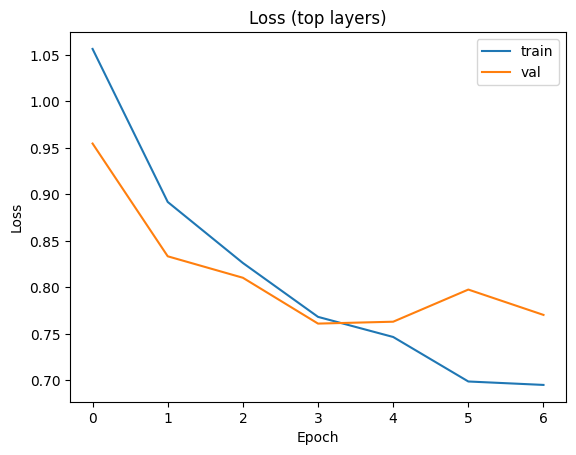

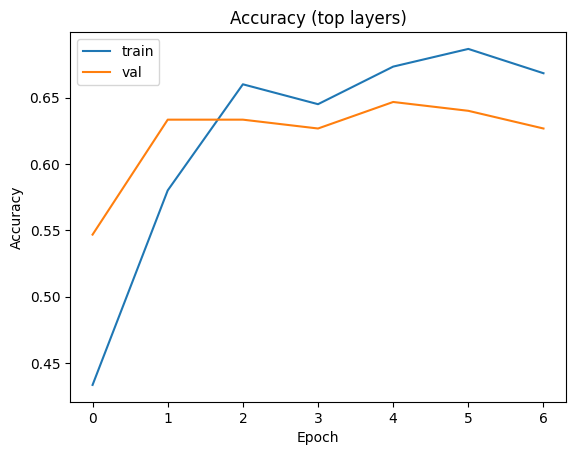

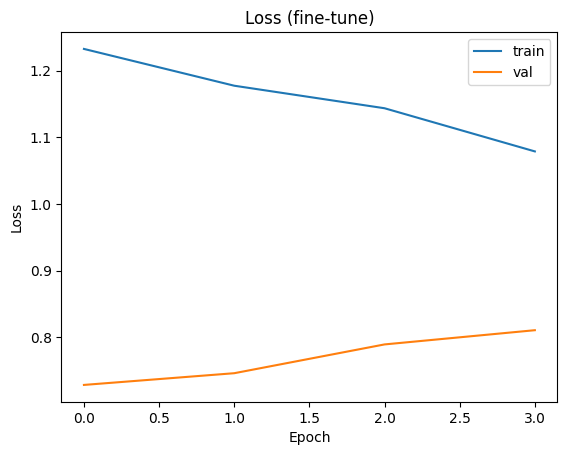

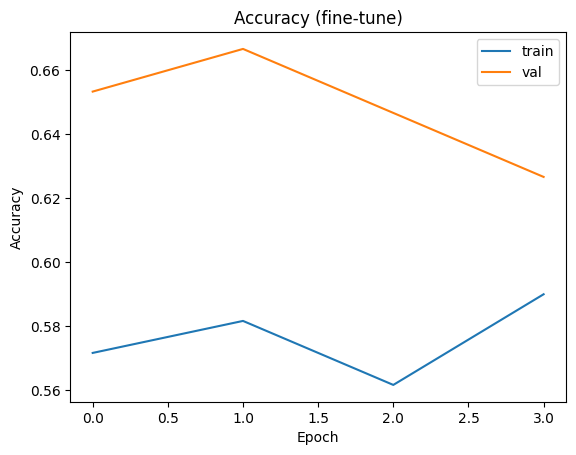

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import (
    EfficientNetB0, preprocess_input,
)
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


# ========== 4. 建立模型：EfficientNetB0 ==========
base = EfficientNetB0(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights="imagenet",
)
base.trainable = False               # 先凍結特徵抽取器

inputs  = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# ========== 5. 訓練頂層 ==========
history_top = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_TOP,
    class_weight=class_weight_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=2
        ),
    ],
)

# ========== 6. 解凍並微調 ==========
base.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # 微調時較小 LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_ALL,
    class_weight=class_weight_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        ),
    ],
)

plot_history(history_top,  "(top layers)")
plot_history(history_fine, "(fine-tune)")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5179 - loss: 1.0187 - val_accuracy: 0.6533 - val_loss: 0.7157
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6915 - loss: 0.6717 - val_accuracy: 0.6800 - val_loss: 0.6714
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7702 - loss: 0.5697 - val_accuracy: 0.7267 - val_loss: 0.6207
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7398 - loss: 0.5888 - val_accuracy: 0.6667 - val_loss: 0.7778
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7755 - loss: 0.5590 - val_accuracy: 0.7467 - val_loss: 0.6214
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8482 - loss: 0.4491 - val_accuracy: 0.7000 - val_loss: 0.6830
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8092 - loss: 0.4626 - val_accuracy: 0.7267 - val_loss: 0.6515
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.814

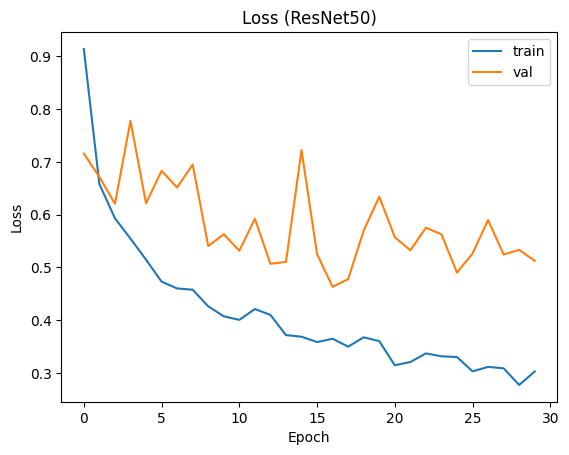

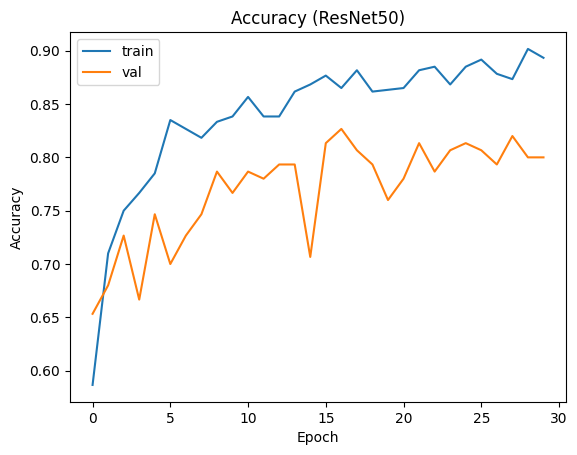

In [5]:
# --- ResNet50 模型訓練 ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input

# 使用 ResNet50，不包含頂層分類器
base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=IMG_SIZE + (3,)))
base_model.trainable = False  # 先凍結特徵提取層

# 加上分類頭
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(class_names), activation="softmax")(x)
model_resnet = Model(inputs=base_model.input, outputs=output)

# 編譯模型
model_resnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 資料前處理（根據 ResNet 要求）
train_ds_resnet = train_ds.map(lambda x, y: (resnet_preprocess(x), y))
val_ds_resnet = val_ds.map(lambda x, y: (resnet_preprocess(x), y))

# 訓練模型
history_resnet = model_resnet.fit(train_ds_resnet, validation_data=val_ds_resnet, epochs=EPOCHS_TOP)

plot_history(history_resnet, title_suffix="(ResNet50)")


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5077 - loss: 1.0240 - val_accuracy: 0.6067 - val_loss: 0.9003
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6075 - loss: 0.8618 - val_accuracy: 0.6600 - val_loss: 0.7869
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6302 - loss: 0.7713 - val_accuracy: 0.6600 - val_loss: 0.7428
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6508 - loss: 0.7514 - val_accuracy: 0.7400 - val_loss: 0.7063
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6770 - loss: 0.6953 - val_accuracy: 0.6800 - val_loss: 0.6934
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7193 - loss: 0.6571 - val_accuracy: 0.7200 - val_loss: 0.6764
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7495 - loss: 0.6091 - val_accuracy: 0.7200 - val_loss: 0.6720
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.752

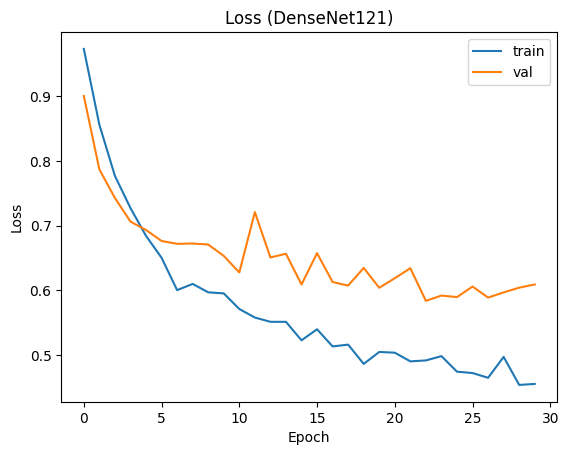

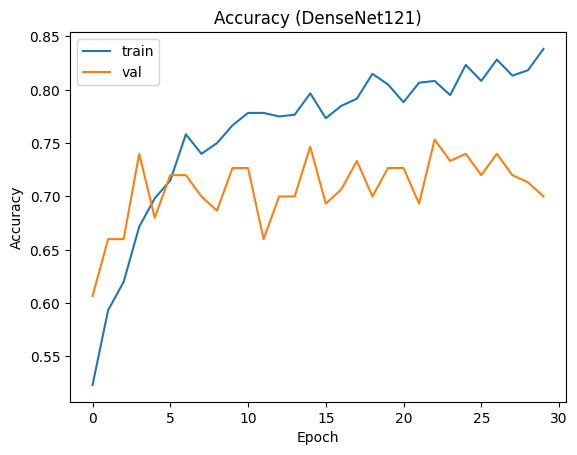

In [6]:
# --- DenseNet121 模型訓練 ---
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

# 使用 DenseNet121，不包含頂層分類器
base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=IMG_SIZE + (3,)))
base_model.trainable = False

# 加上分類頭
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(class_names), activation="softmax")(x)
model_densenet = Model(inputs=base_model.input, outputs=output)

# 編譯模型
model_densenet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 資料前處理（根據 DenseNet 要求）
train_ds_dense = train_ds.map(lambda x, y: (densenet_preprocess(x), y))
val_ds_dense = val_ds.map(lambda x, y: (densenet_preprocess(x), y))

# 訓練模型
history_densenet = model_densenet.fit(train_ds_dense, validation_data=val_ds_dense, epochs=EPOCHS_TOP)

plot_history(history_densenet, title_suffix="(DenseNet121)")